In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Characterization of anomalous diffusion and ergodicity breaking from single trajectories

In this notebook you will find the basic tools to learn how to deal in practice with the topic of diffusion. First, few simple comments about the `andi-datasets` package. we will use this python package to create trajectories of different anomalous diffusion models. You can find a more detailed tutorials in its [github repository](https://github.com/AnDiChallenge/ANDI_datasets).

Let's start by importing and checking the available anomalous diffusion models:

In [2]:
!pip install andi-datasets
!pip install fbm
import andi
print(andi.andi_datasets().avail_models_name)

['attm', 'ctrw', 'fbm', 'lw', 'sbm']


The `andi-datasets` packages allows us then to generate trajectories of these five models. We will learn more about them along the notebook. To generate a set of trajectories of, for instance, Fractional Brownian motion (fbm) and anomalous diffusion exponent $\alpha=0.5$ we just need to do:

In [3]:
T = 200 # Length of the trajectories
N = 5 # Number of trajectories
alpha = 0.5 # Anomalous diffusion exponent
model = 2 # This corresponds to the index of fbm in the previous list

dataset = andi.andi_datasets().create_dataset(T = T, N = N, exponents = alpha, models = model)
labels = dataset[:,:2]
trajs = dataset[:,2:]

`dataset` is a `numpy` matrix whose first two columns indicate the exponent and model of each trajectory (now `labels`) and the rest of the matrix is the trajectory itself (now `trajs`). Let's check how the trajectories look like:

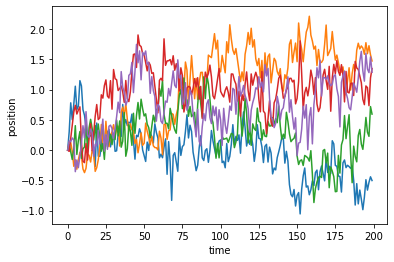

In [ ]:
import matplotlib.pyplot as plt

for traj in trajs:
    plt.plot(traj)
plt.xlabel('time')
plt.ylabel('position')

# Anomalous diffusion exponent

In this section we will show the basic tools to asses the anomalous diffusion exponent of a set of trajectories.

## Time averaged mean squared displacement (TA-MSD)

We will now create a function that calculates the TA-MSD for a given trajectory:

*(Note that this function calculates the TA-MSD for a single trajectory. Using the theoretical definition and the function below, can you rewrite the funcion such that it calculates the TA-MSD for a set of trajectories in an efficient way?)*

In [8]:
def TAMSD(traj, t_lags):
    '''
    Calculates the time average mean squared displacement of a set of trajectories
    Inputs: - traj: trajectory to calculate TA-MSD
            - t_lags: time lags used for the TA-MSD
    Outputs: - TA-MSD
    '''
    tamsd = np.zeros_like(t_lags, dtype= float)
    for idx, t in enumerate(t_lags):        
        for p in range(len(traj)-t):
            tamsd[idx] += (traj[p]-traj[p+t])**2            
        tamsd[idx] /= len(traj)-t    
    return tamsd

Let's use the dataset we created above and calculate the TAMSD of each trajectory and plot it in log-scale. As the trajectories have 200 points, let's choose the time lages $\Delta \in [1,20]$. In addition, we will also plot two lines: one linearly proportional to the $\Delta$ and one proportional to $\Delta^\alpha$. This will give you information about the ergodicity! Can you tell from here if fbm is ergodic or not?

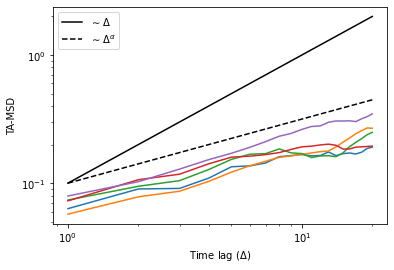

In [ ]:
t_lags = np.arange(1, 21)

for traj in trajs:
    tamsd = TAMSD(traj, t_lags)    
    plt.loglog(t_lags,tamsd)
    
plt.loglog(t_lags, 0.1*t_lags, c = 'k', label = r'$\sim \Delta$')
plt.loglog(t_lags, 0.1*t_lags**alpha, c = 'k', ls = '--', label = r'$\sim \Delta^\alpha$')
plt.xlabel(r'Time lag ($\Delta$)')
plt.ylabel('TA-MSD')
plt.legend()

We can also calculate the ensemble averaged (EA-MSD) and time-ensemble averaged mean squared displacement (TEA-MSD):

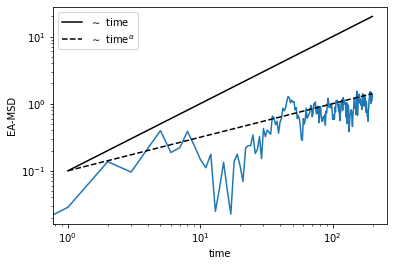

In [ ]:
## EA-MSD ##
eamsd = np.mean(trajs**2, axis = 0)

plt.loglog(eamsd)
plt.loglog(np.arange(1,T), 0.1*np.arange(1,T), c = 'k', label = r'$\sim$ time')
plt.loglog(np.arange(1,T), 0.1*np.arange(1,T)**alpha, c = 'k', ls = '--', label = r'$\sim$ time$^\alpha$')  
plt.xlabel(r'time')
plt.ylabel('EA-MSD')
plt.legend()

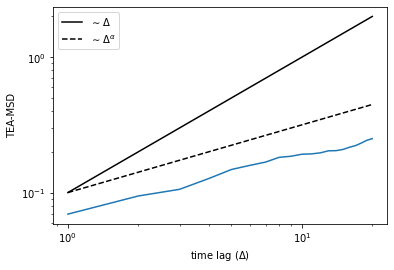

In [ ]:
## TEA-MSD ##
t_lags = np.arange(1, 21)
teamsd = np.zeros_like(t_lags, dtype = 'float64')
for traj in trajs:
    teamsd += TAMSD(traj, t_lags)    
teamsd /= N


plt.loglog(t_lags,teamsd)
plt.loglog(t_lags, 0.1*t_lags, c = 'k', label = r'$\sim \Delta$')
plt.loglog(t_lags, 0.1*t_lags**alpha, c = 'k', ls = '--', label = r'$\sim \Delta^\alpha$')
plt.xlabel(r'time lag ($\Delta$)')
plt.ylabel('TEA-MSD')
plt.legend()

A visual inspection seems to tell us that FBM is ergodic! To confirm it, let's fit the TA-MSD and check if we recover the anomalous diffusion exponent we set above. For that, we will use a fitting function from `numpy`, forcing a linear fit:

Text(0, 0.5, '$\\alpha$')

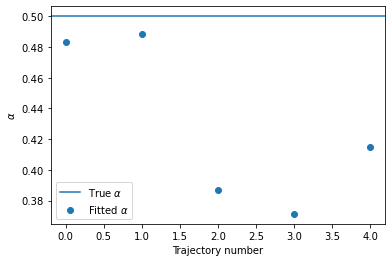

In [ ]:
fitted_alpha = []
for traj in trajs:
    tamsd = TAMSD(traj, t_lags) 
    fitted_alpha.append(np.polyfit(np.log(t_lags), np.log(tamsd),1)[0])
    
plt.scatter(range(N), fitted_alpha, label = r'Fitted $\alpha$')
plt.axhline(alpha, label = r'True $\alpha$')
plt.legend()
plt.xlabel('Trajectory number')
plt.ylabel(r'$\alpha$')

The TA-MSD fit seemed to work, but rather poorly... What can be improved? Solve the exercises to learn about it!

### Trajectories with localization error

The trajectories we used aboved were examples from a purely theoretical fbm. However, in real life things are not so clean and in many experiments we have the appearance of localization noise. A simple way of simulating this is to add Gaussian noise to each of the positions of a trajectory. Here is an example with noise with standard deviation 0.5:

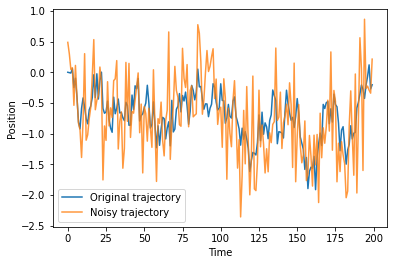

In [ ]:
noisy_trajs = trajs + np.random.randn(N,T)*0.5


plt.plot(trajs[0,:], label = 'Original trajectory')
plt.plot(noisy_trajs[0,:], label = 'Noisy trajectory', alpha = 0.8)
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()

Let's see what happens when we try to predict the anomalous diffusion exponent for this noisy trajectories:

Text(0, 0.5, '$\\alpha$')

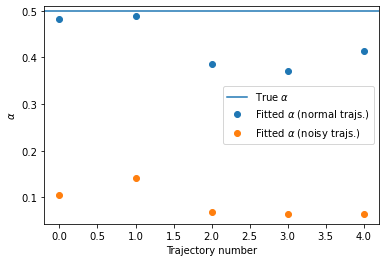

In [ ]:
fitted_alpha_noisy = []
for traj in noisy_trajs:
    tamsd = TAMSD(traj, t_lags) 
    fitted_alpha_noisy.append(np.polyfit(np.log(t_lags), np.log(tamsd),1)[0])
    
plt.scatter(range(N), fitted_alpha, label = r'Fitted $\alpha$ (normal trajs.)')
plt.scatter(range(N), fitted_alpha_noisy, label = r'Fitted $\alpha$ (noisy trajs.)')

plt.axhline(alpha, label = r'True $\alpha$')
plt.legend()
plt.xlabel('Trajectory number')
plt.ylabel(r'$\alpha$')

You can see that the noise has completely erased the information of the anomalous diffusion exponent!! This shows the need for better techniques if one wants to correctly characterize a trajectory. In the last part of this notebook we will show a novel approach based on ML, with much better results!

# Ergodicity breaking

In the cells above we have focused on an ergodic model, FBM. However, we now know that there exist diffusion models that break ergodicity. This means that the time average mean squared displacement (TA-MSD) and the ensemble average mean squared displacement (EA-MSD) are not longer equal. Let's explore this intriguing feature with a very well known non-ergodic model: continuous time random walk (CTRW). We will start by creating a dataset of CTRW trajectories. As we will be perfoming ensemble averages, we will need much more trajectories.

In [6]:
T = 200 # Length of the trajectories
N = 1000 # Number of trajectories
alpha = 0.5 # Anomalous diffusion exponent

# Now we want CTRW trajectories (see list of available models above):
model = 1 

dataset = andi.andi_datasets().create_dataset(T = T, N = N, exponents = alpha, models = model)
labels = dataset[:,:2]
trajs = dataset[:,2:]

This is how CTRW trajectories look like. You will recognize the characteristic waiting times.

Text(0, 0.5, 'Position')

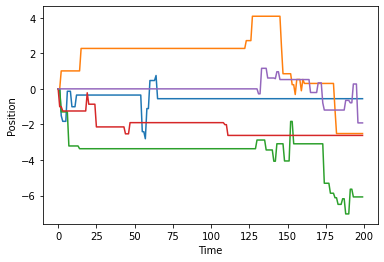

In [ ]:
for traj in trajs[:5,:]:
    plt.plot(traj)
plt.xlabel('Time')
plt.ylabel('Position')

## Ensemble averaged mean squared displacement (EA-MSD)

To showcase the appearance of ergodicity breaking, let's calculate the EA-MSD and the ensemble average of the TA-MSD (TEA-MSD). For the former, if all your trajectories start at zero, it is as easy as to do the mean of the position squared! For the latter, we will use the function we define previously. We will use the same time lags we used for the FBM case.

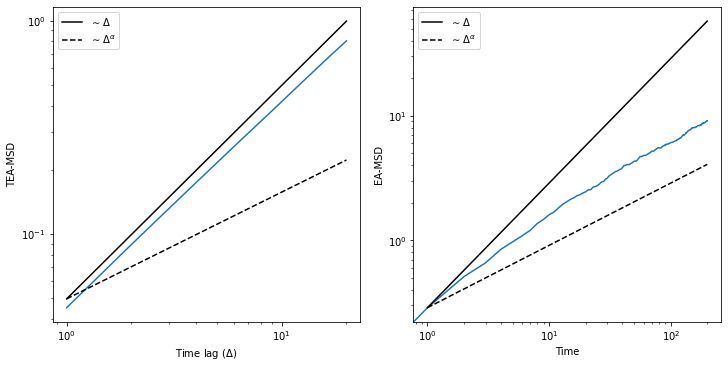

In [16]:
## EA-MSD ##
eamsd = np.mean(trajs**2, axis = 0)

## TEA-MSD ##
t_lags = np.arange(1, 21)
teamsd = np.zeros_like(t_lags, dtype = 'float64')
for traj in trajs:
    teamsd += TAMSD(traj, t_lags)    
teamsd /= N

fig, ax = plt.subplots(1,2, figsize = (10, 5), constrained_layout = True)

ax[0].loglog(t_lags, teamsd)
ax[0].loglog(t_lags, 1.1*teamsd[0]*t_lags, c = 'k', label = r'$\sim \Delta$')
ax[0].loglog(t_lags, 1.1*teamsd[0]*t_lags**alpha, c = 'k', ls = '--', label = r'$\sim \Delta^\alpha$')
plt.setp(ax[0], xlabel =r'Time lag ($\Delta$)', ylabel = 'TEA-MSD')
ax[0].legend()


ax[1].loglog(eamsd)
ax[1].loglog(np.arange(1,T), eamsd[1]*np.arange(1,T), c = 'k', label = r'$\sim \Delta$')
ax[1].loglog(np.arange(1,T), eamsd[1]*np.arange(1,T)**alpha, c = 'k', ls = '--', label = r'$\sim \Delta^\alpha$')  
plt.setp(ax[1], xlabel =r'Time', ylabel = 'EA-MSD')
ax[1].legend()

As we can clearly see, the TEA-MSD is linearly proportional to the time lags $\Delta$ while the EA-MSD is propotional to $t^\alpha$, showcasing the break of ergodicity.

## Ergodicity breaking parameter

A quantitative approach to ergodicity breaking is the calculation of the ergodicity breaking parameter (EB). Here is how to calculate it:

In [ ]:
def EB(trajs, t_lag):
    eb = []
    # We loop over T, which is the point at which we cut the trajectory
    for T in range(t_lag+1, trajs.shape[1]):
        cut_trajs = trajs[:,:T]
        # Now we calculate the TAMSD for every trajectory at the
        # given t_lag
        tamsd = np.zeros(trajs.shape[0])
        for idx, traj in enumerate(cut_trajs):   
            for p in range(len(traj)-t_lag):
                tamsd[idx] += (traj[p]-traj[p+t_lag])**2            
        tamsd /= len(traj)-t_lag
        # Compute EB and append
        eb.append(np.mean(tamsd**2)/np.mean(tamsd)**2-1)
    return eb

Let's compute the EB for similar trajectories to the ones we used in the previous section. The expected value at $t\rightarrow\infty$ is given by Eq.(8) of [this paper](https://arxiv.org/pdf/0807.4793.pdf) and for $\alpha = 0.5$ we should have EB$\approx 0.570$. As a bonus, let's create some FBM trajectories to check that for ergodic processes, the EB goes to zero, even when the anomalous diffusion exponent is different than one. We will use as time lag $\Delta = 2$. You can check the effect of varying $\Delta$ on the EB in the previous paper (see e.g. Fig. 2(b)).

*Note: the EB is much slower because you need a couple of extra loops. If you managed to create the efficient function for the TA-MSD, now is the time to use it!*

In [ ]:
T = 200 # Length of the trajectories
N = 500 # Number of trajectories
alpha = 0.5 # Anomalous diffusion exponent


fbm = andi.andi_datasets().create_dataset(T = T, N = N, exponents = alpha, models = 2)[:,2:]
ctrw = andi.andi_datasets().create_dataset(T = T, N = N, exponents = alpha, models = 1)[:,2:]

In [ ]:
EB_ctrw = EB(ctrw, t_lag = 2)
EB_fbm = EB(fbm, t_lag = 2)

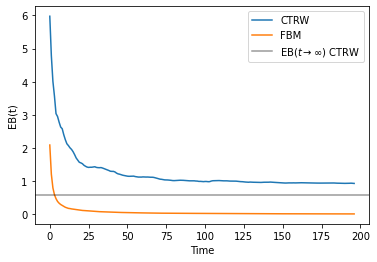

In [ ]:
plt.plot(EB_ctrw, label = 'CTRW')
plt.plot(EB_fbm, label = 'FBM')
plt.axhline(0.570, c = 'k', alpha = 0.4, label = r'EB($t\rightarrow\infty$) CTRW')
plt.ylabel('EB(t)')
plt.xlabel('Time')
plt.legend()

As you can see, the EB for the FBM trajectories quickly goes to 0. However, for the CTRW we see a value different that zero, that will converge to the theoretical value if we consider much longer trajectories. Feel free to explore how long you have to wait until reaching such value!

# Machine learning approach to single trajectory characterization

As we just saw, analyzing diffusion processes at the single trajectory level has many problems related to, e.g. noise, trajectory length, ergodicity breaking,... In the last years we have seen how machine learning can indeed solve many of this. Here we will show an example on how to use a convolutional neural network to decide wether the anomalous diffusion exponent of a dataset of trajectories.

### Training and test dataset

Let's start by creating the datasets that we will use for training and evaluating the trained machine. We will consider for this example a dataset of FBM trajectories, with exponents $\in [0.2,1.4]$ and lenght 200. For training we need a big dataset, so we will generate 10000 trajectories:

In [ ]:
exponents = np.arange(0.2,1.81, 0.4)
N = 2000 # this is the number of trajectories per exponent, which makes a total of 10000
T = 200 # Length of the trajectories

dataset = andi.andi_datasets().create_dataset(T = T, N = N, exponents = exponents, models = 2)

We will now transform the previous dataset to a machine learning dataset which we can then input to the neural network. The shape constraints are set by the machines we will later use. Moreover, we will split the dataset into a training and test datasets with a 80%/20% ratio. Moreover, we will use the function `normalize` from the `andi-datasets` package to ensure that all the trajectories are in the same scale. This function divides the displacements of a trajectory by their standard deviation. This changes the diffusion coefficient of any trajectory to $D=1$, but the anomalous diffusion exponent remains untouched. Moreover, it is also important to shuffle our dataset.

In [ ]:
ratio = int(0.8*dataset.shape[0])
np.random.shuffle(dataset)
# NN inputs: trajectories
X_train = andi.normalize(dataset[:ratio, 2:]).reshape(ratio, T, 1)
X_test = andi.normalize(dataset[ratio:, 2:]).reshape(N-ratio, T, 1)

# NN outputs: their anomalous exponent
Y_train = dataset[:ratio, 1]
Y_test = dataset[ratio:, 1]

### Neural network architecture

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2 as regularizer_l2


model = Sequential()


model.add(Conv1D(filters=3, kernel_size=3 ,strides=1,   
                 input_shape=(T, 1),
                 kernel_initializer= 'uniform',      
                 activation= 'relu', kernel_regularizer = regularizer_l2(l = 0.001)))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

model.add(Conv1D(filters=8, kernel_size=5 ,strides=1,  
                 kernel_initializer= 'uniform',      
                 activation= 'relu', kernel_regularizer = regularizer_l2(l = 0.001)))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))   

model.add(Conv1D(filters=3, kernel_size=2 ,strides=1,  
                 kernel_initializer= 'uniform',      
                 activation= 'relu', kernel_regularizer = regularizer_l2(l = 0.001)))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64*2, activation='sigmoid', kernel_regularizer = regularizer_l2(l = 0.001)))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

As we want to extract the anomalous diffusion exponent, the output layer needs to have size one. It is also important that its activation function is linear. 

In [ ]:
model.add(Dense(1, activation='linear'))

Now we compile the model. For the loss function, we will use the mean absolute error (MAE). Another possible choice is the mean squared error (MSE). We will keep track of it as metric. We will use Adam as optimizer.

In [ ]:
model.compile(loss='mean_absolute_error',
              optimizer=Adam(),
              metrics=['accuracy'])

At last, we train! 

In [ ]:
batch_size = 200
epochs = 150

training = model.fit(X_a, Y_a,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(X_e, Y_e))

In order to see if the training worked, let's take a look at the training and test dataset accuracy:

In [ ]:
acc = history_fcn.history['accuracy']
val_acc = history_fcn.history['val_accuracy']

plt.plot(np.arange(len(history_fcn.history['accuracy'])), acc, label='Training acc')
plt.plot(np.arange(len(history_fcn.history['accuracy'])), val_acc,label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Extracting other parameters with ML

Now that we defined our network, it is really easy to transform it for any other task. For instance, let's see how to create a machine that distinguishes between ergodic and non-ergodic trajectories. First we need to create a new dataset with all the `andi-datasets` diffusion models. Due to the constraints of the package, we will need to create the subdiffusive and superdiffusive datasets separately and then merge them:

In [18]:
N = 200 # this is the number of trajectories per exponent, which makes a total of 10000
T = 200 # Length of the trajectories

subdiffusive_exponents = np.arange(0.2, 1, 0.2) # We only consider subdiffusion
subdiffusive_models = [0, 1, 2, 4] # All models but LW

sub_dataset = andi.andi_datasets().create_dataset(T = T, N = N, exponents = subdiffusive_exponents, models = subdiffusive_models)

superdiffusive_exponents = np.arange(1, 2, 0.2) # We only consider superdiffusion
superdiffusive_models = [2, 3, 4] # All models but CTRW and ATTM

super_dataset = andi.andi_datasets().create_dataset(T = T, N = N, exponents = superdiffusive_exponents, models = superdiffusive_models)

dataset = np.vstack((sub_dataset, super_dataset))

C:\Users\Gorka\anaconda3\lib\site-packages\fbm\fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(


The labels now need to be transform such that for ATTM, CTRW and SBM we have 0 (non-ergodic) and for FBM and LW we will have 1 (ergodic):

In [23]:
ratio = int(0.8*dataset.shape[0])
np.random.shuffle(dataset)
# NN inputs: trajectories
X_train = andi.normalize(dataset[:ratio, 2:]).reshape(ratio, T, 1)
X_test = andi.normalize(dataset[ratio:, 2:]).reshape(N-ratio, T, 1)

# NN outputs
# First we take the models
Y_train = dataset[:ratio, 0]
Y_test = dataset[ratio:, 0]

where_ergodic = np.argwhere((Y_train == 2) | (Y_train == 3))
where_nonergodic = np.argwhere((Y_train == 0) | (Y_train == 1) | (Y_train == 4))
Y_train[where_ergodic] = 0
Y_train[where_nonergodic] = 0

where_ergodic = np.argwhere((Y_test == 2) | (Y_test == 3))
where_nonergodic = np.argwhere((Y_test == 0) | (Y_test == 1) | (Y_test == 4))
Y_test[where_ergodic] = 0
Y_test[where_nonergodic] = 0

Finally, we can use the same architecture as before, but will need to change the last layer to two neurons with softmax activation, as e.g.:

In [ ]:
model.add(Dense(2, activation='softmax'))